In [ ]:
import solaris as sol
import os
import glob
import gdal
from tqdm import tqdm
import cv2
import shutil
import pandas as pd
import numpy as np
from skimage.morphology import square, dilation
from matplotlib import pyplot as plt
from solaris.eval.iou import calculate_iou
import geopandas as gpd
from datetime import datetime

/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework

In [ ]:
root= "/cowc/datasets/ground_truth_sets"  ##cowc ground_truth_sets location after download
original_masks = "/cowc/original-masks" ## un-dialated masks
masks_out= "/cowc/masks" ##output location for your masks for training
images_out= "/cowc/tiles" ##output location for your tiled images for testing
masks_test_out= "/cowc/masks_test" ##output location for your masks for testing
images_test_out= "/cowc/tiles_test" ##output location for your tiled images for testing

os.chdir(root)
dirs=glob.glob("*/")

Reset masks and tiles

In [ ]:
!rm /cowc/tiles_test/* /cowc/masks_test/*
!cp /cowc/original-masks/* /cowc/masks
!cp /cowc/original-tiles/* /cowc/tiles

Normalizing ...

In [ ]:
M1=[]
M2=[]
M3=[]
S1=[]
S2=[]
S3=[]
driver = gdal.GetDriverByName("GTiff")
os.chdir(images_out)
images=glob.glob("*.tif")
for image in images:
    band=gdal.Open(image).ReadAsArray()
    M1.append(np.mean(band[0,:,:]))
    M2.append(np.mean(band[1,:,:]))
    M3.append(np.mean(band[2,:,:]))
    S1.append(np.std(band[0,:,:]))
    S2.append(np.std(band[1,:,:]))
    S3.append(np.std(band[2,:,:]))

print("Save these numbers for your solaris.yml file for training and z-scoring (normalizing) your imagery")
print(np.mean(M1)/255)
print(np.mean(M2)/255)
print(np.mean(M3)/255)
print(np.mean(S1)/255)
print(np.mean(S2)/255)
print(np.mean(S3)/255)

Save these numbers for your solaris.yml file for training and z-scoring (normalizing) your imagery
0.494178484222375
0.4912501544331696
0.4446247830106799
0.14198320654223198
0.1348343093094483
0.13263025441360382


In [ ]:
if not os.path.exists(images_test_out):
        os.makedirs(images_test_out)
os.chdir(images_out)
images = glob.glob("12TVL*")
for image in tqdm(images):
    output = os.path.join(images_test_out,image)
    shutil.move(image, output)

if not os.path.exists(masks_test_out):
        os.makedirs(masks_test_out)
os.chdir(masks_out)
images = glob.glob("12TVL*")
for image in tqdm(images):
    output = os.path.join(masks_test_out,image)
    shutil.move(image, output)

100%|██████████| 4037/4037 [00:00<00:00, 54560.65it/s]


In [ ]:
data = []
images = []
image_folder=images_out
label_folder=masks_out
os.chdir(label_folder)
labels=glob.glob("*.tif")
for x in labels:
    z = x.split('_Annotated_Cars')[0] + x.split('_Annotated_Cars')[1]
    os.chdir(image_folder)
    image=glob.glob(z)
    if len(image) != 1:
        os.chdir(label_folder)
        os.remove(x)        
    else:
        images.append(image[0])
        
for image, label in zip(images,labels):
    image = os.path.join(image_folder,image)
    label = os.path.join(label_folder,label)
    data.append((image, label))

df = pd.DataFrame(data, columns=['image', 'label'])
df.to_csv(os.path.join(root,"train_data_df.csv"))

In [ ]:
data = []
images = []
image_folder=images_test_out
label_folder=masks_test_out
os.chdir(label_folder)
labels=glob.glob("*.tif")
for x in labels:
    z = x.split('_Annotated_Cars')[0] + x.split('_Annotated_Cars')[1]
    os.chdir(image_folder)
    image=glob.glob(z)
    if len(image) != 1:
        os.chdir(label_folder)
        os.remove(x)        
    else:
        images.append(image[0])
        
for image, label in zip(images,labels):
    image = os.path.join(image_folder,image)
    label = os.path.join(label_folder,label)
    data.append((image, label))

df = pd.DataFrame(data, columns=['image', 'label'])
df.to_csv(os.path.join(root,"test_data_df.csv"))

In [ ]:
print(datetime.now().strftime("Started training %d/%m/%Y %H:%M:%S"))
config = sol.utils.config.parse('/cowc/xdxd_vehicleDetection-1.yml')
trainer = sol.nets.train.Trainer(config)
trainer.train()
print(datetime.now().strftime("Finished training %d/%m/%Y %H:%M:%S"))

Started training 08/10/2021 19:21:30
Beginning training epoch 0
    loss at batch 0: 14.091440200805664
    loss at batch 10: 2.5668036937713623
    loss at batch 20: 2.5179545879364014
    loss at batch 30: 2.482048749923706
    loss at batch 40: 2.4221065044403076
    loss at batch 50: 2.2890164852142334
    loss at batch 60: 1.898093342781067
    loss at batch 70: 2.097874164581299
    loss at batch 80: 1.8704780340194702
    loss at batch 90: 2.1146273612976074
    loss at batch 100: 2.0574278831481934
    loss at batch 110: 2.0117530822753906
    loss at batch 120: 2.0314218997955322
    loss at batch 130: 1.9872276782989502
    loss at batch 140: 2.0638537406921387
    loss at batch 150: 1.9092965126037598
    loss at batch 160: 1.7373158931732178
    loss at batch 170: 1.7475085258483887
    loss at batch 180: 1.937652826309204
    loss at batch 190: 1.6929690837860107
    loss at batch 200: 1.5896795988082886
    loss at batch 210: 1.5622997283935547
    loss at batch 220: 1.56

In [ ]:
inference_output="/cowc/e-1/inference_out"  ## The location that you output inference results to as specified in your yml.
inference_output_bin="/cowc/e-1/inference_out_binary"  ## A location to store binarized outputs
inference_polygon_dir="/cowc/e-1/inference_polys" ## Outputs polygonized
ground_truth_polygon_dir="/cowc/e-1/ground_truth_polys" ## Ground Truth Outputs polygonized

if not os.path.exists(inference_output):
    os.makedirs(inference_output)
if not os.path.exists(inference_output_bin):
    os.makedirs(inference_output_bin)
if not os.path.exists(inference_polygon_dir):
    os.makedirs(inference_polygon_dir)
if not os.path.exists(ground_truth_polygon_dir):
    os.makedirs(ground_truth_polygon_dir)

In [ ]:
print(datetime.now().strftime("Started inference %d/%m/%Y %H:%M:%S"))
config = sol.utils.config.parse('/cowc/xdxd_vehicleDetection-1.yml')
inf_df = sol.nets.infer.get_infer_df(config)
inferer = sol.nets.infer.Inferer(config)
inferer(inf_df)
print(datetime.now().strftime("Finished inference %d/%m/%Y %H:%M:%S"))

Started inference 08/10/2021 20:38:42


/opt/conda/envs/solaris/lib/python3.7/site-packages/solaris/nets/infer.py:23: UserWarning: Because the configuration specifies both training and inference, solaris is switching the model weights path to the training output path.
  warn('Because the configuration specifies both training and '


Finished inference 08/10/2021 20:43:11


In [ ]:
from solaris.vector.mask import mask_to_poly_geojson
driver = gdal.GetDriverByName("GTiff")

os.chdir(inference_output)
images=glob.glob("*.tif")
for image in tqdm(images):
    band=gdal.Open(image)
    band = band.ReadAsArray()
    band[np.where((band > 0))] = 1  ### Note that these values may be model specific and change slightly due to reimplementations.  For simplicity I threshold at 0.
    band[np.where((band <= 0))] = 0
    im_out = driver.Create(os.path.join(inference_output_bin,image),band.shape[1],band.shape[0],1,gdal.GDT_Byte)
    im_out.GetRasterBand(1).WriteArray(band)
    del im_out
    output=os.path.join(inference_polygon_dir,image.split(".")[0]+".geojson") 
    gdf=mask_to_poly_geojson(band,reference_im=os.path.join(images_test_out,image),min_area=1,simplify=True)
    if not gdf.empty:
        gdf.to_file(output, driver='GeoJSON')
        
        
os.chdir(masks_test_out)
images=glob.glob("*.tif")
for image in tqdm(images):
    band=gdal.Open(image)
    band = band.ReadAsArray()
    output=os.path.join(ground_truth_polygon_dir,image.split(".")[0]+".geojson") 
    image=image.split("_Annotated_Cars")[0]+image.split("_Annotated_Cars")[1]
    gdf=mask_to_poly_geojson(band,reference_im=os.path.join(images_test_out,image),min_area=1,simplify=True)
    if not gdf.empty:
        gdf.to_file(output, driver='GeoJSON')

100%|██████████| 4037/4037 [00:37<00:00, 106.40it/s]


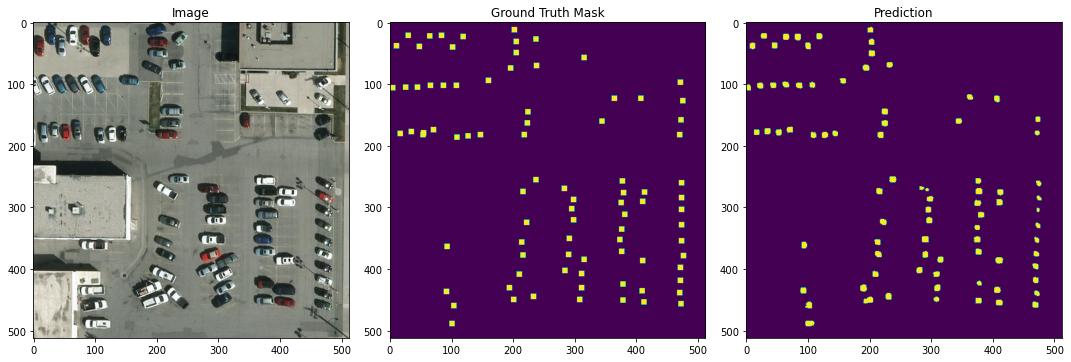

In [ ]:
image = os.path.join(images_test_out,"12TVL240120.png_tile_519.tif")
mask = os.path.join(masks_test_out,"12TVL240120_Annotated_Cars.png_tile_519.tif")
prediction = os.path.join(inference_output_bin,"12TVL240120.png_tile_519.tif")
image = gdal.Open(image).ReadAsArray()
mask = gdal.Open(mask).ReadAsArray()
prediction = gdal.Open(prediction).ReadAsArray()

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(np.moveaxis(image,0,2))
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Ground Truth Mask')
ax[2].imshow(prediction)
ax[2].set_title('Prediction')
plt.tight_layout()

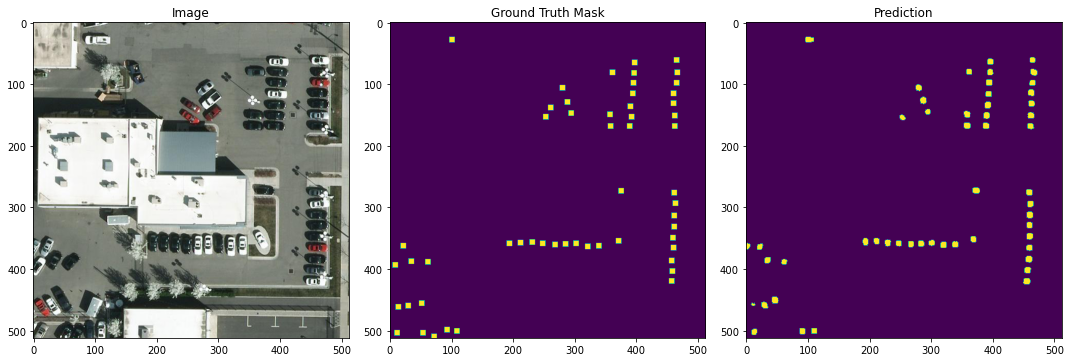

In [ ]:
image = os.path.join(images_test_out,"12TVL240120.png_tile_520.tif")
mask = os.path.join(masks_test_out,"12TVL240120_Annotated_Cars.png_tile_520.tif")
prediction = os.path.join(inference_output_bin,"12TVL240120.png_tile_520.tif")
image = gdal.Open(image).ReadAsArray()
mask = gdal.Open(mask).ReadAsArray()
prediction = gdal.Open(prediction).ReadAsArray()

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(np.moveaxis(image,0,2))
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Ground Truth Mask')
ax[2].imshow(prediction)
ax[2].set_title('Prediction')
plt.tight_layout()

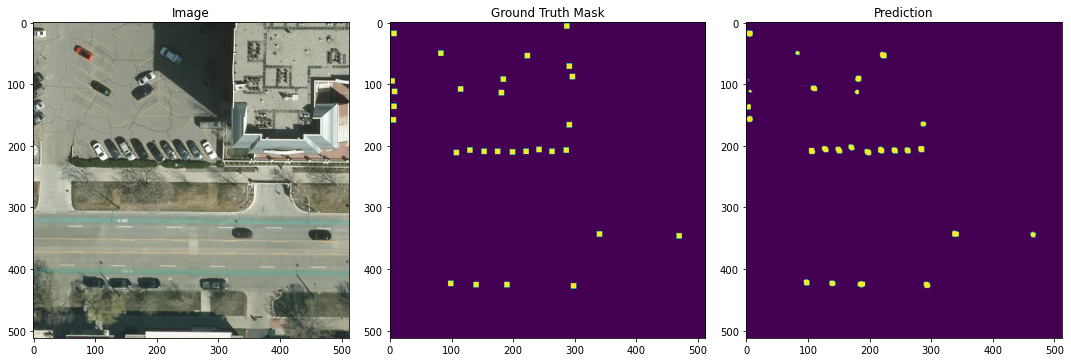

In [ ]:
image = os.path.join(images_test_out,"12TVL240120.png_tile_500.tif")
mask = os.path.join(masks_test_out,"12TVL240120_Annotated_Cars.png_tile_500.tif")
prediction = os.path.join(inference_output_bin,"12TVL240120.png_tile_500.tif")
image = gdal.Open(image).ReadAsArray()
mask = gdal.Open(mask).ReadAsArray()
prediction = gdal.Open(prediction).ReadAsArray()

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(np.moveaxis(image,0,2))
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Ground Truth Mask')
ax[2].imshow(prediction)
ax[2].set_title('Prediction')
plt.tight_layout()

In [ ]:
def precision_calc(proposal_polygons_dir,groundtruth_polygons_dir,file_format="geojson"):
    ious=[]
    os.chdir(proposal_polygons_dir)
    search = "*" + file_format
    proposal_geojsons=glob.glob(search)
    for geojson in tqdm(proposal_geojsons):
        ground_truth_poly = os.path.join(groundtruth_polygons_dir,geojson)
        if os.path.exists(ground_truth_poly):
            ground_truth_gdf=gpd.read_file(ground_truth_poly)
            proposal_gdf=gpd.read_file(geojson)
            for index, row in (proposal_gdf.iterrows()):
                iou=calculate_iou(row.geometry, ground_truth_gdf)
                if 'iou_score' in iou.columns:
                    iou=iou.iou_score.max()
                    ious.append(iou)
                else:
                    iou=0
                    ious.append(iou)
    return ious

def recall_calc(proposal_polygons_dir,groundtruth_polygons_dir,file_format="geojson"):
    ious=[]
    os.chdir(groundtruth_polygons_dir)
    search = "*" + file_format
    gt_geojsons=glob.glob(search)
    for geojson in tqdm(gt_geojsons):
        proposal_poly = os.path.join(proposal_polygons_dir,geojson)
        if os.path.exists(proposal_poly):
            proposal_gdf=gpd.read_file(proposal_poly)
            gt_gdf=gpd.read_file(geojson)
            for index, row in (gt_gdf.iterrows()):
                iou=calculate_iou(row.geometry, proposal_gdf)
                if 'iou_score' in iou.columns:
                    iou=iou.iou_score.max()
                    ious.append(iou)
                else:
                    iou=0
                    ious.append(iou)
    return ious
    
def f1_score(precision_ious,recall_ious,threshold=0.5):
    items=[]
    for i in precision_ious:
        if i >=threshold:
            items.append(1)
        else:
            items.append(0)
    
    precision= np.mean(items)
    
    items=[]
    for i in recall_ious:
        if i >=threshold:
            items.append(1)
        else:
            items.append(0)
    recall= np.mean(items)
    
    f1 = 2* precision * recall/(precision + recall)
    return f1

def simple_average_precision(precisions_ious,threshold=0.5):
    items=[]
    for i in precision_ious:
        if i >=threshold:
            items.append(1)
        else:
            items.append(0)
    
    precision= np.mean(items)
    return precision

In [ ]:
# Score our results
precision_ious = precision_calc(inference_polygon_dir,ground_truth_polygon_dir,file_format="geojson")
recall_ious = recall_calc(inference_polygon_dir,ground_truth_polygon_dir,file_format="geojson")
print(f1_score(precision_ious,recall_ious,threshold=0.25), "F1 Score@0.25")
print(f1_score(precision_ious,recall_ious,threshold=0.5), "F1 Score@0.5") ## The traditional SpaceNet metric
print(simple_average_precision(precision_ious,threshold=0.25), "AP@0.25") ## Acceptable for small objects like cars!
print(simple_average_precision(precision_ious,threshold=0.5), "AP@0.5")

100%|██████████| 8/8 [00:00<00:00, 13535.47it/s]

nan F1 Score@0.25
nan F1 Score@0.5
nan AP@0.25
nan AP@0.5



/opt/conda/envs/solaris/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/envs/solaris/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
